# Проект 8. Возьмёте Бэтмобиль?
Макарова Елена

# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*за основу взят ноутбук (Baseline) к текущему соревнованию!*   

> (**Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline сделано следующее:
* Построина "наивную"/baseline модель, предсказывающая цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаны и отнормированны признаки
* Сделана первая модель на основе градиентного бустинга с помощью CatBoost
* Сделана вторая модель на основе нейронных сетей + сравнение результатов
* Сделана multi-input нейронная сеть для анализа табличных данных и текста одновременно
* Добавили в multi-input сеть обработку изображений
* Осуществили ансамблирование

In [1]:
# # путь к файлу, доступ через google colab
# from google.colab import drive
# drive.mount('/content/drive')
# path = './drive/My Drive/Colab Notebooks/skillfactory/Юнит 9. NLP-Computer Vision'

In [2]:
#!pip install -q tensorflow==2.3

In [3]:
#аугментации изображений
#!pip install albumentations -q

In [4]:
#аугментации изображений
!pip install albumentations catboost -q

In [5]:
!pip install pymorphy2
!pip install pymorphy2-dicts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 672.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 15.1 MB/s eta 0:00:00


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pymorphy2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
!pip install category-encoders
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor

In [8]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.21.6
Tensorflow   : 2.6.4


In [9]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_pred-y_true)/y_true))
# Функция подсчёта метрики MAPE
def mape(y_true, y_pred,show=False):
    met = np.mean(np.abs((y_pred-y_true)/y_true)) 
   #Вывод информации
    if show:
        print('mape={:.2f}%'.format(met))
    return met

In [10]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)

In [11]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [12]:
!pip install kaggle

In [13]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c sf-dst-car-price-prediction-part2 --force
# !unzip -oq sf-dst-car-price-prediction-part2.zip

In [14]:
# # читаем данные с диска для colab
# train = pd.read_csv(path + '/train.csv')
# test = pd.read_csv(path + '/test.csv')
# sample_submission = pd.read_csv(path+ '/sample_submission.csv')
# pd.set_option('display.max_columns', None)

DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [15]:
sample_submission.nunique()

sell_id    1671
price         1
dtype: int64

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [17]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [18]:
train.head(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [19]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=43)

In [20]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == {row[1]}"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.92%


In [21]:
#Разделение выборки на обучающую и валидационную. и посмотрим 
trn, val = train_test_split(train,test_size=0.15,shuffle=True,random_state=42)
#Наивная модель
predicts = []
for index, row in pd.DataFrame(val[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == {row[1]}"
    predicts.append(trn.query(query)['price'].median())
#Если не нашлись совпадение, то медианным значением
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())
#Вывод
print(f"Точность наивной модели по MAPE: {(mape(val['price'], predicts.values[:, 0]))*100:0.2f}%.")

Точность наивной модели по MAPE: 19.88%.


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

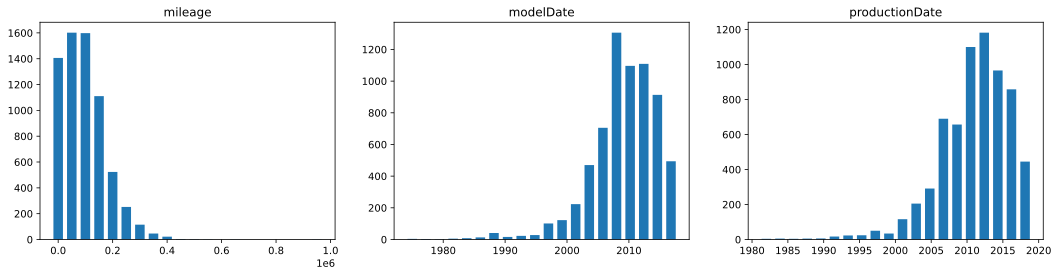

In [22]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

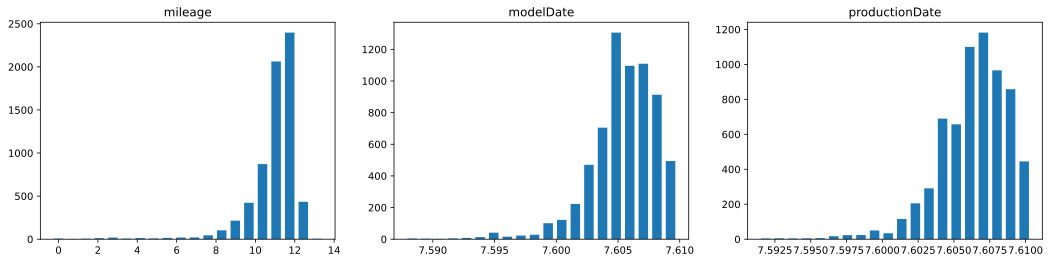

In [23]:

# Посмотрим сразу на логарифмированные числовые признаки
visualize_distributions({
    'mileage': np.log(train['mileage'].dropna()),
    'modelDate': np.log(train['modelDate'].dropna()),
    'productionDate': np.log(train['productionDate'].dropna())
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

Посмотрим на число пропусков - только один признак - Владение имеет множество пропусков

In [24]:
train.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [25]:
test.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  0
Владение                1092
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

Сравним состав датасетов по признакам


In [26]:
#столбцы train  которые отсутствуют в test  
test_col_unique = list(set(train.columns)-set(test.columns))
print(len(test_col_unique))
print(test_col_unique)

1
['price']


In [27]:
#столбцы test которые отсутствуют в train  
train_col_unique = list(set(test.columns)-set(train.columns))
print(len(train_col_unique))
print(train_col_unique)

0
[]


In [28]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['is_train'] = 1 # помечаем где у нас трейн
test['is_train'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)


(6682, 23) (1671, 23) (8353, 23)


## первичный EDA

In [29]:
# # используем модуль для быстрого первичного анализа данных https://pandas-profiling.ydata.ai/docs/master/index.html
# ! pip install https://pandas-profiling.ydata.ai/docs/master/index.html 
# import pandas_profiling
# pandas_profiling.ProfileReport(train)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

 num_cols:

* is_train - признак,характеризующий отношения данных к датасет train или test, удалить из num_cols
* numberOfDoors - количество дверей авто, перенесем к категориальным признакам
* sell_id - код продавца, удалить из num_cols
* price - целевой признак, выделим отдельно


In [31]:
# Посмотрим %-ое соотношение пропусков

data.isnull().sum()[train.isnull().sum() >0] /8353*100


Владельцы     0.011972
Владение     64.862924
dtype: float64

Что можно сказать на данный момент по данным: в тренировочной выборке 6682 объявлений, в тестовой - 1671. Всего данных - 8353 объявлений. Имеется 23 признака. Из числовых признаков у нас: mileage, modelDate, numberOfDoors, productionDate. Остальные - типа Object. Пропуски в признаках Владельцы (0.01%) и Владение(65%). Также добавился признак is_train для обозначения принадлежности данных и последующего разделения

In [32]:
data.head(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,is_train,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0


## обработка признаков

In [33]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'is_train', 'price'],
      dtype='object')

In [34]:
def uniq_info(col): # количеству уникальных значений
    print(f"Уникальных значений: {col.nunique()}")
    print(col.value_counts(dropna=False))

### цена (price) - Целевая переменная

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


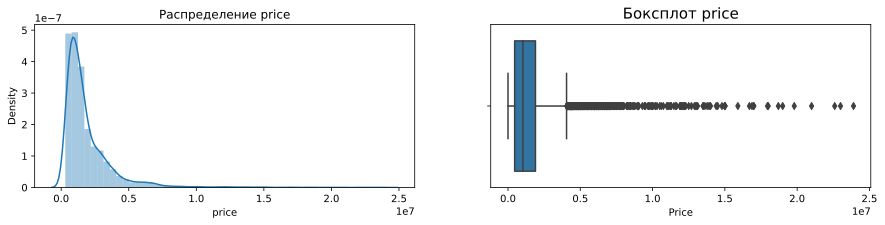

count    8.353000e+03
mean     1.519804e+06
std      1.873130e+06
min      0.000000e+00
25%      4.600000e+05
50%      1.030000e+06
75%      1.900000e+06
max      2.390000e+07
Name: price, dtype: float64

In [35]:
#Целевая переменная - цена (price)

# train_price = data[data.is_train == 1].price
# train_price.hist(bins=1000, figsize=[17, 8])
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1)
plt.title(f"Распределение {'price'}")
sns.distplot((data[data['is_train'] == 1]['price']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['price'])
plt.xlabel('Price')
plt.title(f"Боксплот {'price'}", fontsize=15)
plt.show()
data.price.describe()


экспоненциальное распределение. 

Логарифмируем цену.

Заодно предварительно поделим цены на 1000, т.к. в большинстве случаев цена кратна 1000.

чтобы не сломалось наше предсказание, сразу объявим метод восстановления цены.

Новую целевую переменную для удобства сохраним в отдельный столбец

In [36]:
data['price_log'] = np.log(1 + (data.price / 1000)) 

def predict_price_log(y_pred):
    return np.round(np.exp(y_pred) - 1) * 1000

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


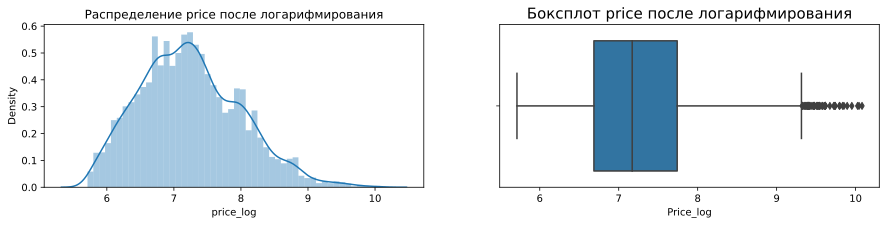

In [37]:

plt.figure(figsize=(15, 3))
plt.subplot(1,2,1)
plt.title(f"Распределение {'price'} после логарифмирования")
sns.distplot((data[data['is_train'] == 1]['price_log']), bins=50)

plt.subplot(1,2,2)
sns.boxplot((data[data['is_train'] == 1]['price_log']))
plt.xlabel('Price_log')
plt.title('Боксплот price после логарифмирования', fontsize=15)
plt.show()

### Объем двигателя (engineDisplacement)

In [38]:
uniq_info(data['engineDisplacement'])

Уникальных значений: 48
2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
2.4 LTR            44
3.1 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
6.6 LTR             5
1.9 LTR             5
5.8 LTR             5
4.6 LTR             5
4.3 LTR             4
3.4 LTR             4
3.8 LTR 

In [39]:
# Приведем к числовому виду

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda s: '0' if (s == 'undefined LTR') else s)
#для удобства и получения целых знвчений, умножим на 10
data['engineDisplacement'] = data['engineDisplacement'].str.split(' ').apply(lambda s: float(s[0]))
uniq_info(data['engineDisplacement'])

Уникальных значений: 48
2.0    2430
3.0    2349
1.8     411
1.6     410
4.4     329
5.5     268
3.5     250
2.5     248
2.1     221
4.0     153
4.7     137
2.8     106
1.4     106
4.2     103
5.0      74
1.5      73
3.2      60
2.2      58
4.8      57
2.9      50
2.4      44
3.1      44
6.2      40
6.0      37
5.4      33
1.2      33
1.3      32
2.7      24
4.1      23
3.6      23
1.7      15
2.3      14
3.7      14
5.2      13
5.9      11
2.6       9
0.0       6
0.7       6
6.6       5
1.9       5
5.8       5
4.6       5
4.3       4
3.4       4
3.8       3
6.3       3
5.6       3
4.9       2
Name: engineDisplacement, dtype: int64


<AxesSubplot:>

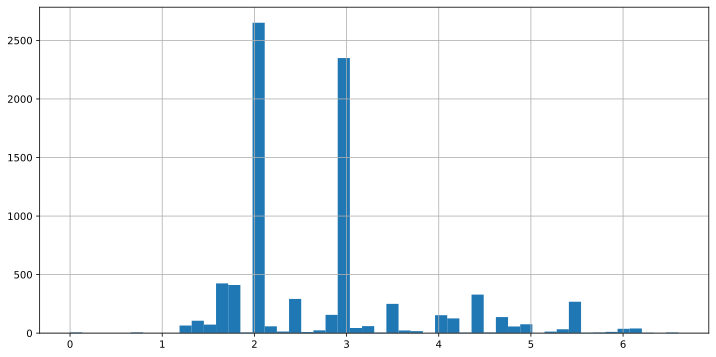

In [40]:
data['engineDisplacement'].hist(bins=50, figsize=[12, 6])

### Мощность двигателя (enginePower)

In [41]:
# Преобразуем в целое, удалив N12

data['enginePower'] = data['enginePower'].str.split(' ').apply(lambda s: int(s[0]))

uniq_info(data['enginePower'])

Уникальных значений: 154
184    759
249    655
190    420
245    355
306    344
      ... 
520      1
132      1
430      1
591      1
174      1
Name: enginePower, Length: 154, dtype: int64


<AxesSubplot:>

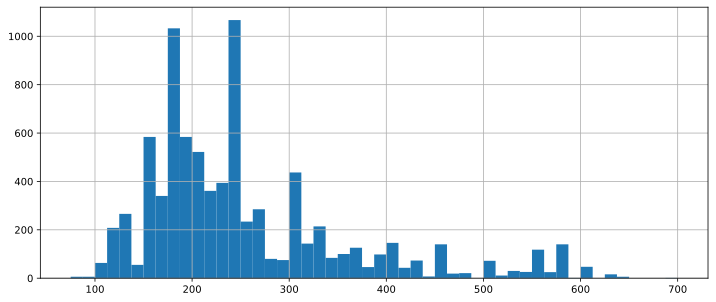

In [42]:
data['enginePower'].hist(bins=50, figsize=[12, 5])

### Год модели и выпуска ('modelDate', 'productionDate')

In [43]:
# Создадим новый признак  количество лет (модели и выпуска)  (modelAge,productionAge)

data['modelAge']=(2022-data['modelDate'])
data['productionAge']=(2022-data['productionDate'])

<AxesSubplot:>

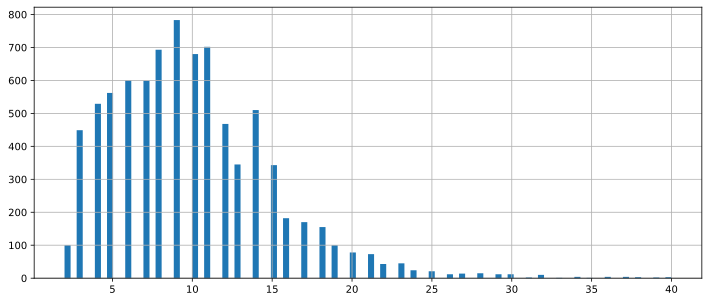

In [44]:
data['productionAge'].hist(bins=100, figsize=[12, 5])

<AxesSubplot:ylabel='modelAge'>

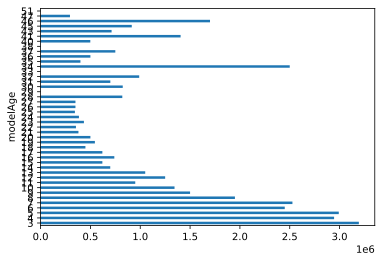

In [45]:
#Посмотрим зависимость стоимости от возраста
data.groupby('modelAge').price.median().plot(kind='barh')

<AxesSubplot:ylabel='productionDate'>

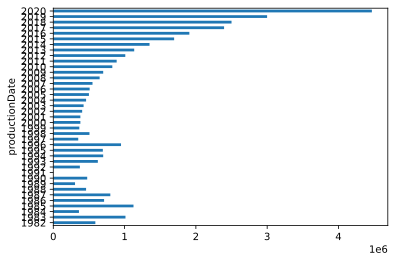

In [46]:
#Посмотрим зависимость стоимости от возраста н
data.groupby('productionDate').price.median().plot(kind='barh')

<AxesSubplot:ylabel='modelDate'>

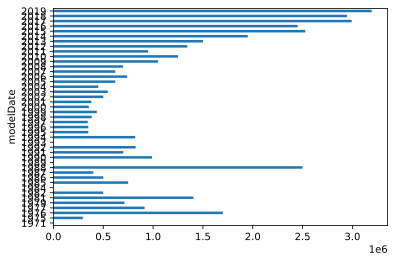

In [47]:
#Посмотрим зависимость стоимости от возраста н
data.groupby('modelDate').price.median().plot(kind='barh')

Видим, что до 1998 года идет закономерное снижение цены.

А у более ранних авто уже нет такого снижения цены! можно добавить признак раритетности.

Также добавим признак, если авто произведено в последнем году, т.к. визуально сильно выделяется цена для него

### новый признак Раритетности (rare)

In [48]:
#признак раритетности
data['rare'] = data['modelDate'].apply(lambda x: 1 if x<1996 else 0) 

In [49]:
uniq_info(data['rare'])

Уникальных значений: 2
0    8177
1     176
Name: rare, dtype: int64


### новый признак произвелено в последнем году  (LY_prod)

In [50]:
#произведено в последнем году  ну т.е типо новая, но еще и пробег надо посмотреть 
data['LY_prod'] = data['productionDate'].apply(lambda x: 1 if x==data['productionDate'].max() else 0) 

In [51]:
uniq_info(data['LY_prod'])

Уникальных значений: 2
0    8253
1     100
Name: LY_prod, dtype: int64


### Владельцы

In [52]:
uniq_info(data['Владельцы'])

Уникальных значений: 3
3 или более    3311
1 владелец     2526
2 владельца    2515
NaN               1
Name: Владельцы, dtype: int64


In [53]:
# Преобразуем к целому и заполним пустые значения

data['Владельцы'] = data['Владельцы'].astype('str')
data['Владельцы'] = data['Владельцы'].str.split(' ').apply(lambda s: (s[0].split('\xa0')[0]))
data['Владельцы'] = data['Владельцы'].apply(lambda s: 2 if (s == 'nan') else s)
data['Владельцы'] = data['Владельцы'].astype(int)


<AxesSubplot:>

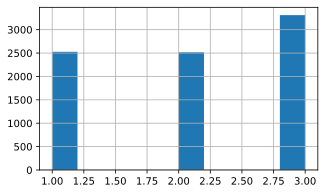

In [54]:
data['Владельцы'].hist( figsize=[5, 3])

### Владение

In [55]:
#uniq_info(data['Владение'])

In [56]:
# срок владения и переведем его в дробные годы.

months = data['Владение'].str.extract(r'(\d{1,2})\sмесяц').astype('float')
years = data['Владение'].str.extract(r'(\d{1,2})\s(?:лет|год)').astype('float')

data['Владение'] = np.round(years + (months / 12), 2)
data['Владение'].isna().sum()

5986

Пропусков в данном признаке слишком много, попробуем заполнить пропуски (год выпуска(в годах) поделим на кол-во владельцев)

In [57]:
data['Владение'] = data['Владение'].fillna(round((data['productionAge']/data['Владельцы']),2))
data['Владение'].isna().sum()

0

In [58]:
uniq_info(data['Владение'])

Уникальных значений: 188
3.00     759
4.00     643
5.00     552
6.00     355
3.67     292
        ... 
15.50      1
21.00      1
15.83      1
14.42      1
34.00      1
Name: Владение, Length: 188, dtype: int64


### Тип кузова (bodyType)

In [59]:
uniq_info(data['bodyType'])

Уникальных значений: 17
седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
внедорожник 3 дв.          5
лимузин                    5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64


In [60]:
# уберем информацию про двери, так как есть отдельный признак
data['bodyType'] = data.bodyType.apply(lambda s: s.split(' ')[0])
uniq_info(data['bodyType'])


Уникальных значений: 13
седан           3542
внедорожник     2905
купе             543
хэтчбек          421
лифтбек          299
универсал        196
минивэн          178
купе-хардтоп     111
родстер           88
кабриолет         54
компактвэн         8
лимузин            5
пикап              3
Name: bodyType, dtype: int64


<AxesSubplot:>

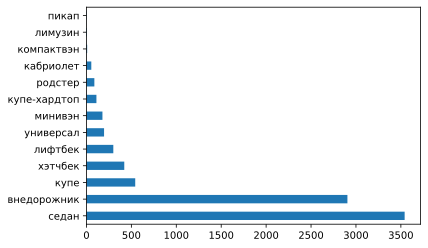

In [61]:
#посмотрим на распределение
data.bodyType.value_counts().plot.barh()

### Цвет (color)

In [62]:
uniq_info(data['color'])

Уникальных значений: 16
чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64


<AxesSubplot:>

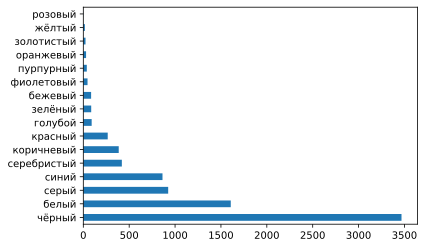

In [63]:
data.color.value_counts().plot.barh()

### (fuelType)

In [64]:
data.fuelType.value_counts() #категориальный признак

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

<AxesSubplot:xlabel='fuelType', ylabel='count'>

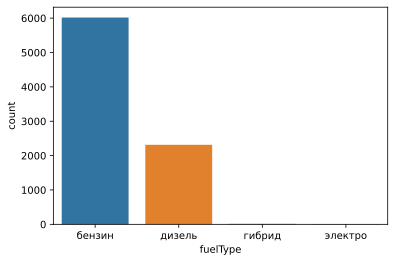

In [65]:
sns.countplot(x = 'fuelType', data = data)

### ПТС

In [66]:
data['ПТС'].value_counts() #категориальный признак

Оригинал    7474
Дубликат     879
Name: ПТС, dtype: int64

<AxesSubplot:xlabel='ПТС', ylabel='count'>

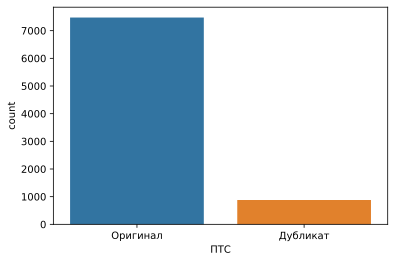

In [67]:
sns.countplot(x = 'ПТС', data = data)

### Руль

In [68]:
data['Руль'].value_counts() #категориальный признак

Левый     8351
Правый       2
Name: Руль, dtype: int64

<AxesSubplot:xlabel='Руль', ylabel='count'>

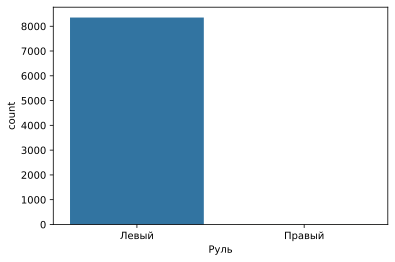

In [69]:
sns.countplot(x = 'Руль', data = data)

###  Количество дверей (numberOfDoors)

In [70]:
uniq_info(data['numberOfDoors'])

Уникальных значений: 4
5    3854
4    3636
2     802
3      61
Name: numberOfDoors, dtype: int64


In [71]:
# поменяем тип, чтоб отнести к категориаьным признакам.
data['numberOfDoors'] = data['numberOfDoors'].astype({'numberOfDoors': np.object})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


<AxesSubplot:xlabel='numberOfDoors', ylabel='count'>

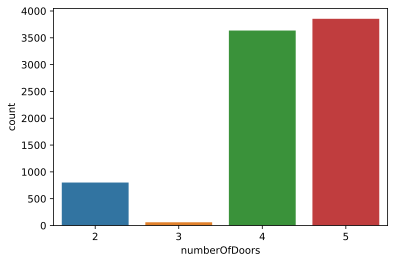

In [72]:
sns.countplot(x = 'numberOfDoors', data = data)

### Конфигурация (vehicleConfiguration)

In [73]:
uniq_info(data['vehicleConfiguration'])

Уникальных значений: 312
ALLROAD_5_DOORS AUTOMATIC 3.0    1292
SEDAN AUTOMATIC 2.0               941
SEDAN AUTOMATIC 3.0               631
ALLROAD_5_DOORS AUTOMATIC 2.0     524
ALLROAD_5_DOORS ROBOT 2.0         226
                                 ... 
ALLROAD_OPEN AUTOMATIC 5.5          1
SEDAN MECHANICAL 3.8                1
SEDAN MECHANICAL 2.3                1
SEDAN MECHANICAL 4.2                1
LIMOUSINE AUTOMATIC 6.0             1
Name: vehicleConfiguration, Length: 312, dtype: int64


In [74]:
# признак состоит из значений 4 других признаков: bodyType,engineDisplacement, numberOfDoors и vehicleTransmission. Можно смело от него избавиться

data.drop(columns='vehicleConfiguration', inplace=True)


### новый признак - количество лощадей на единицу обьема двигателя, электро = 0 (pow_eng)

In [75]:

# Создадим новый признак - количество лощадей на единицу обьема двигателя, электро = 0

def round_int(x):
    if x == float("inf") or x == float("-inf") or x == float("nan"):
        return float('nan') # or x or return whatever makes sense
    elif x>0:
        return float(round(x))
    else:
        print(x)
        return str(round(x))

data['pow_eng'] = (data['enginePower']/data['engineDisplacement'])
data['pow_eng'] = data['pow_eng'].apply(round_int)
data['pow_eng'] = data['pow_eng'].fillna(0)
data['pow_eng'] = data['pow_eng'].astype(int)
uniq_info(data['pow_eng'])

Уникальных значений: 112
92     774
83     500
106    436
102    385
78     323
      ... 
139      1
33       1
263      1
49       1
48       1
Name: pow_eng, Length: 112, dtype: int64


<AxesSubplot:>

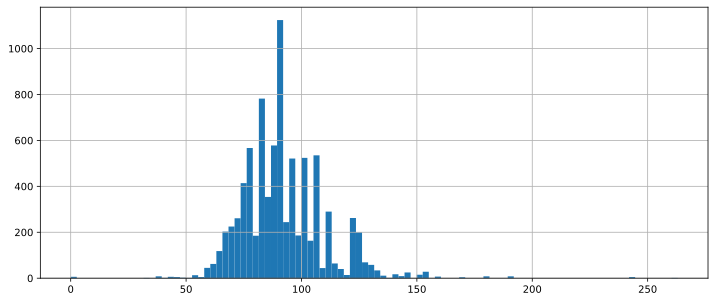

In [76]:
data['pow_eng'].hist(bins=100, figsize=[12, 5])

### новый признак "километраж в год" (mil_year)

In [77]:

# Создадим новый признак "километраж в год"

data['mil_year'] = (data['mileage']/data['productionAge'])
data['mil_year'] = data['mil_year'].apply(round_int)
data['mil_year'] = data['mil_year'].fillna(data['mileage'])
data['mil_year'] = data['mil_year'].astype(int)
uniq_info(data['mil_year'])

Уникальных значений: 4219
10000    79
15000    72
11000    43
12500    43
12000    42
         ..
14760     1
12414     1
16231     1
13970     1
819       1
Name: mil_year, Length: 4219, dtype: int64


<AxesSubplot:>

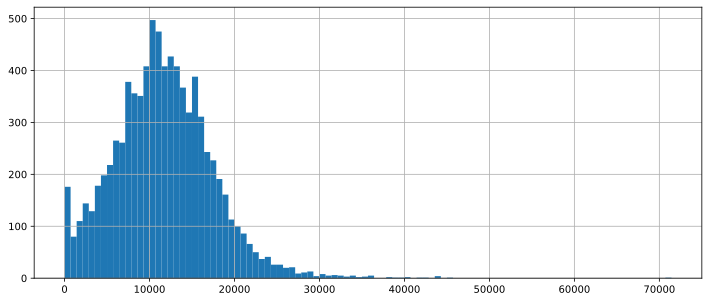

In [78]:
data['mil_year'].hist(bins=100, figsize=[12, 5])

### name  и новый 'name_xDrive'

In [79]:
uniq_info(data['name'])

Уникальных значений: 976
35i 3.0 AT (306 л.с.) 4WD          151
2.0 AMT (211 л.с.) 4WD             145
200 2.0 AT (184 л.с.)              137
30d 3.0d AT (249 л.с.) 4WD         109
400 3.0 AT (333 л.с.) 4WD           97
                                  ... 
300 3.0d AT (190 л.с.) 4WD           1
111 CDI L3 2.2d MT (116 л.с.)        1
200 2.0 AT (136 л.с.)                1
320 Long 3.0d AT (211 л.с.) 4WD      1
Pullman 6.0 AT (394 л.с.)            1
Name: name, Length: 976, dtype: int64


некоторая информация в этом признаке, есть в других. Но можно выделить из признака новый - есть ли система xDrive или нет.

In [80]:
data['name_xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)

uniq_info(data['name_xDrive'])

Уникальных значений: 2
0    7414
1     939
Name: name_xDrive, dtype: int64


In [81]:
# поменяем тип, чтоб отнести к категориаьным признакам.
data['name_xDrive'] = data['name_xDrive'].astype({'name_xDrive': np.object})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


<AxesSubplot:xlabel='name_xDrive', ylabel='count'>

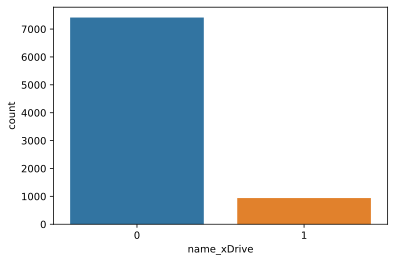

In [82]:
sns.countplot(x = 'name_xDrive', data = data)

### новый признак (new) по кол-ву пробега

In [83]:
#добавим признак нового авто по отсутствию пробега - условно считаем меньше 300
data['new'] = data['mileage'].apply(lambda x: 1 if x<500 else 0)

In [84]:
uniq_info(data['new'])

Уникальных значений: 2
0    8252
1     101
Name: new, dtype: int64


## Feature engineering

<AxesSubplot:>

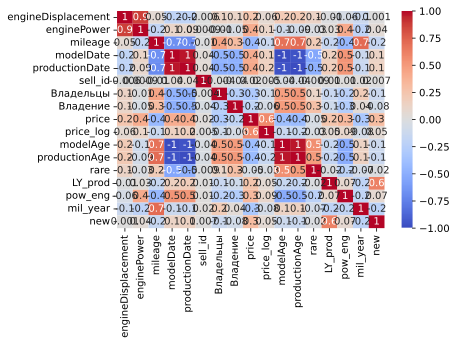

In [85]:
# Попробуем уменьшить размерность данных
# посмотрим на тепловую карту корреляции
sns.heatmap(data.drop(columns=['is_train']).corr(),fmt='.1g', annot=True, cmap='coolwarm')


Высокая корреляция между столбцами modelDate и productionDate, modelAge и productionAge - можно оставить один столбец , например, productionAge .

Еще между 'engineDisplacement',
       'enginePower', но пока оставим оба, а один сделаем object

In [86]:
# заметили что этот признак лучше оставить категориальным, потому что если он числовой результаты хуже.
data['engineDisplacement'] = data['engineDisplacement'].astype(object)

In [87]:
#data.drop(columns=['modelDate','modelAge','productionDate'], inplace=True)   удалим позднее

In [88]:
# Сохраним обработанный датасет для последующего его использования в алгоритмах обучения

data.to_csv('train_data_batmobil.csv', index=False)


### проанализируем распределения числовых признаков

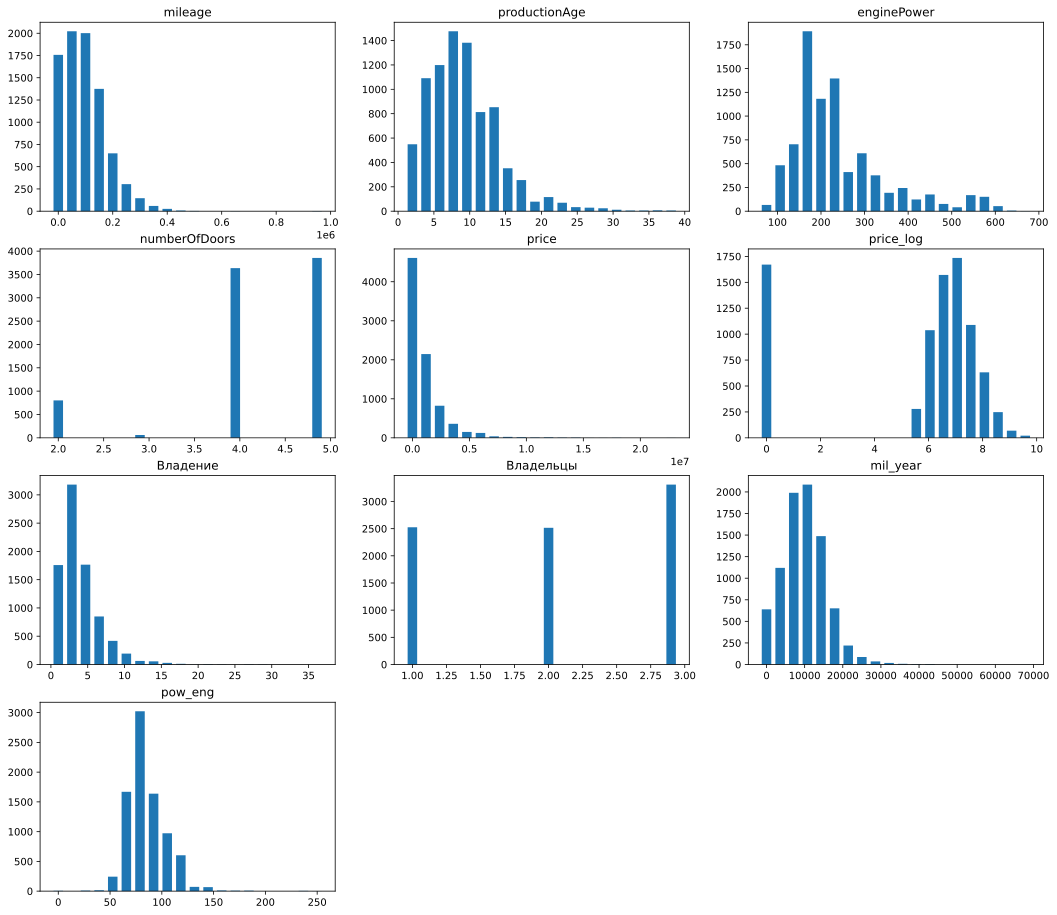

In [89]:
# Посмотрим, как выглядят распределения числовых признаков.

visualize_distributions({
    'mileage': data['mileage'].dropna(),
    'productionAge': data['productionAge'].dropna(),
    'enginePower': data['enginePower'].dropna(),
    'numberOfDoors': data['numberOfDoors'].dropna(),
    'price': data['price'].dropna(),
    'price_log': data['price_log'].dropna(),
    'Владение': data['Владение'].dropna(),
    'Владельцы': data['Владельцы'].dropna(),
    'mil_year': data['mil_year'].dropna(),
    'pow_eng': data['pow_eng'].dropna()
})


распределения несимметричны, перед обучением моделей необходима нормировка

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             8353 non-null   object 
 1   brand                8353 non-null   object 
 2   color                8353 non-null   object 
 3   description          8353 non-null   object 
 4   engineDisplacement   8353 non-null   object 
 5   enginePower          8353 non-null   int64  
 6   fuelType             8353 non-null   object 
 7   mileage              8353 non-null   int64  
 8   modelDate            8353 non-null   int64  
 9   model_info           8353 non-null   object 
 10  name                 8353 non-null   object 
 11  numberOfDoors        8353 non-null   object 
 12  productionDate       8353 non-null   int64  
 13  sell_id              8353 non-null   int64  
 14  vehicleTransmission  8353 non-null   object 
 15  Владельцы            8353 non-null   i

### отсортируем признаки

In [91]:
# cat_cols = data.select_dtypes(include=[object]).columns
# cat_cols

In [92]:
# num_cols = data.select_dtypes(include=[int]).columns
# num_cols 

In [93]:
#  категориальные 
cat_cols = ['bodyType', 'brand', 'color', 'engineDisplacement','fuelType', 'model_info', 
            'numberOfDoors','vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'name_xDrive']

# числовые признаки
num_cols = ['enginePower', 'mileage', 'productionAge', 
            'Владельцы', 'pow_eng', 'mil_year','Владение','rare', 'LY_prod',
            'modelDate', 'productionDate','modelAge']

# пометка принадлежности к датасету 'is_train'   

# текстовые, требущие обработки сетью
NL_col = ['description', 'name']

# этот признак для подгрузки изображения  'sell_id'

# целевой признак
target = ['price']
target_log = ['price_log']

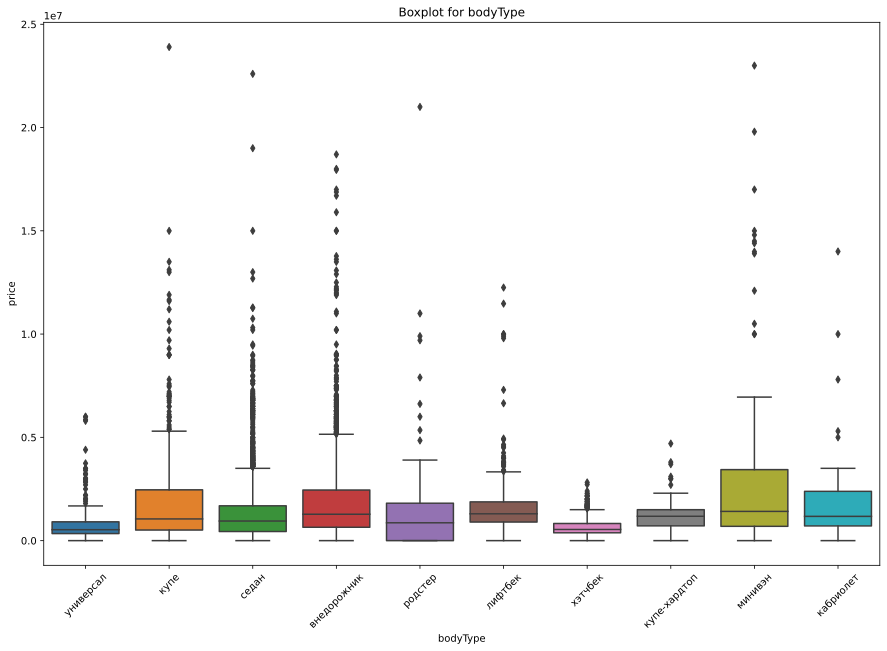

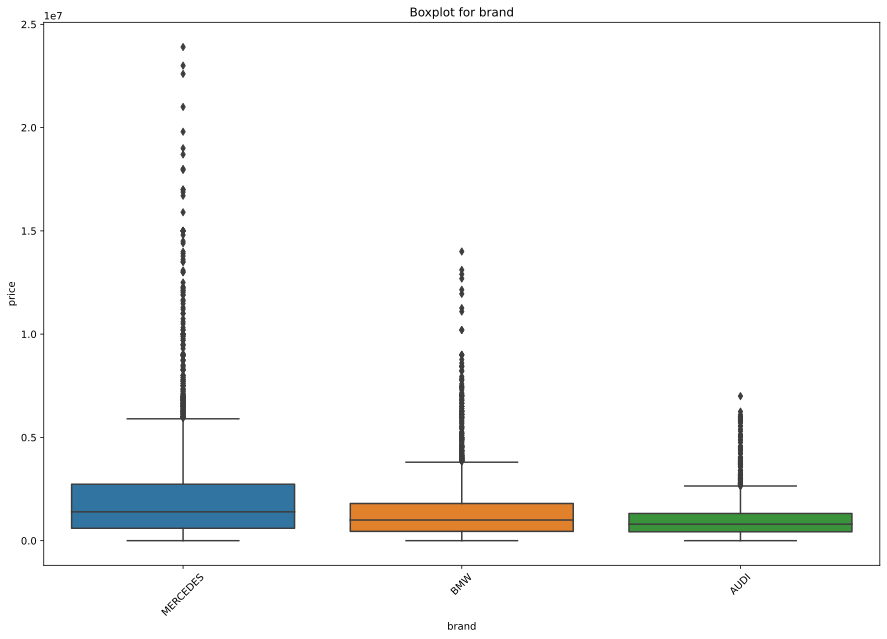

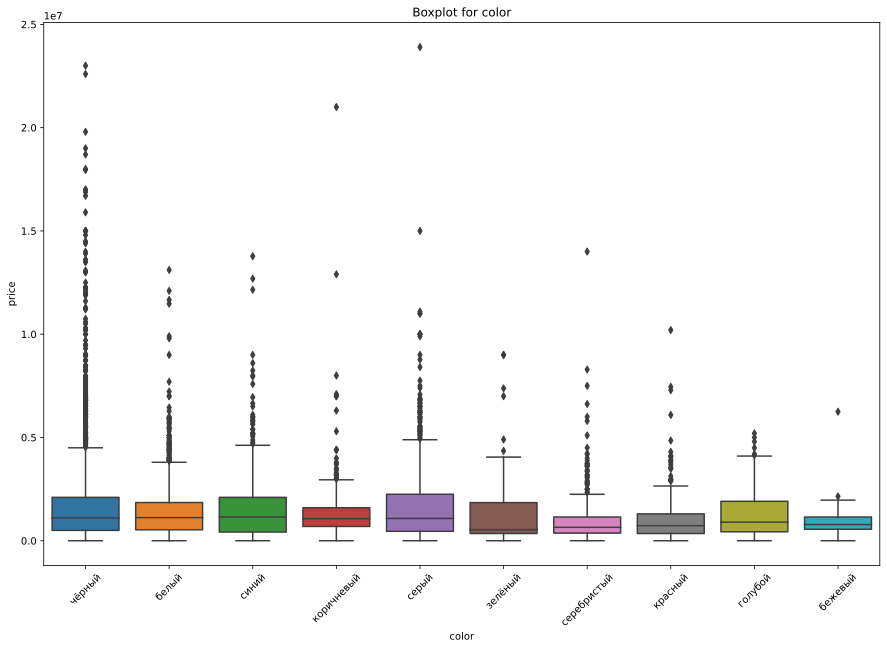

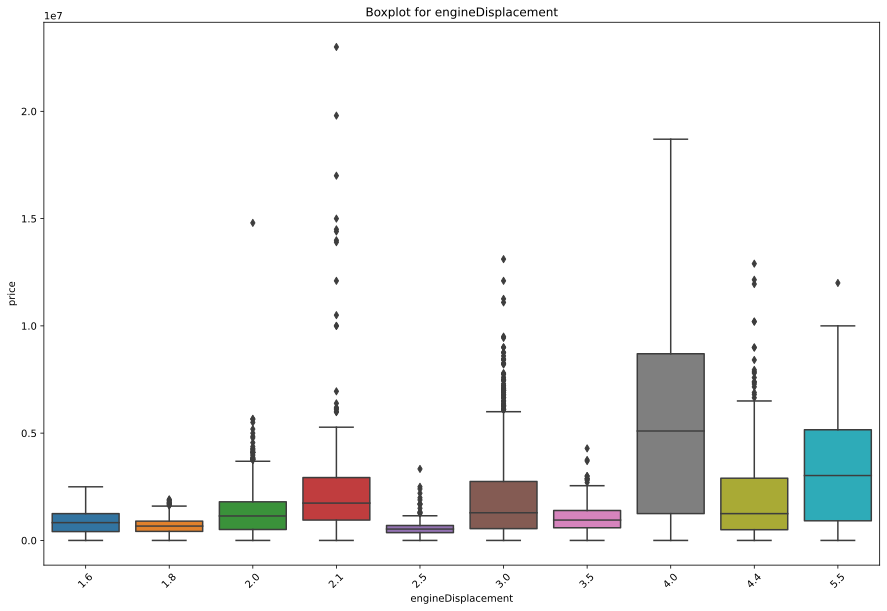

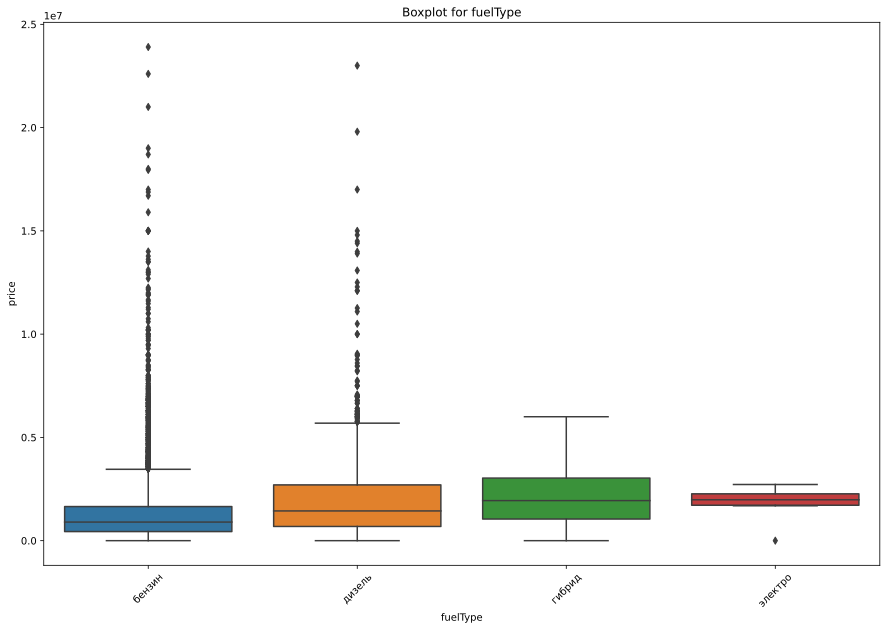

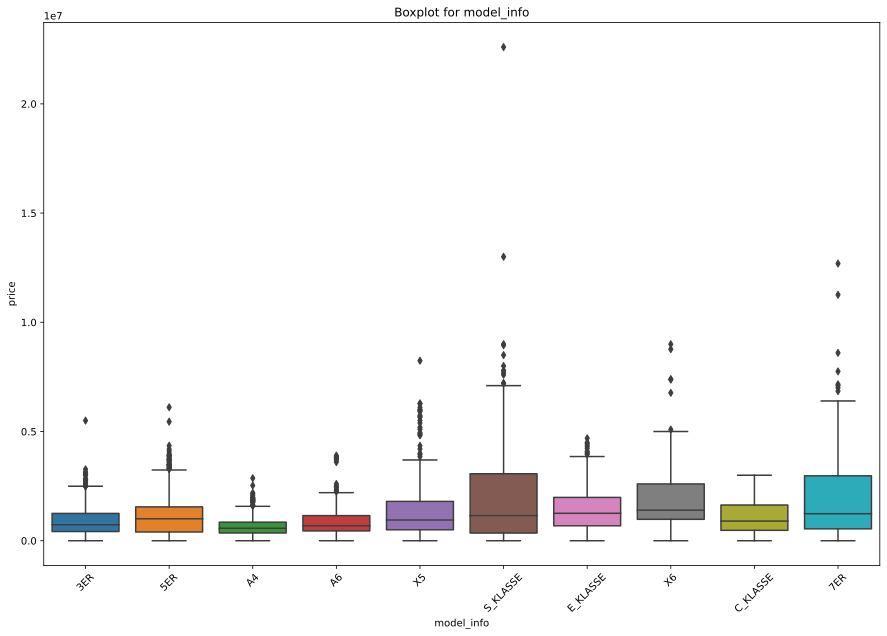

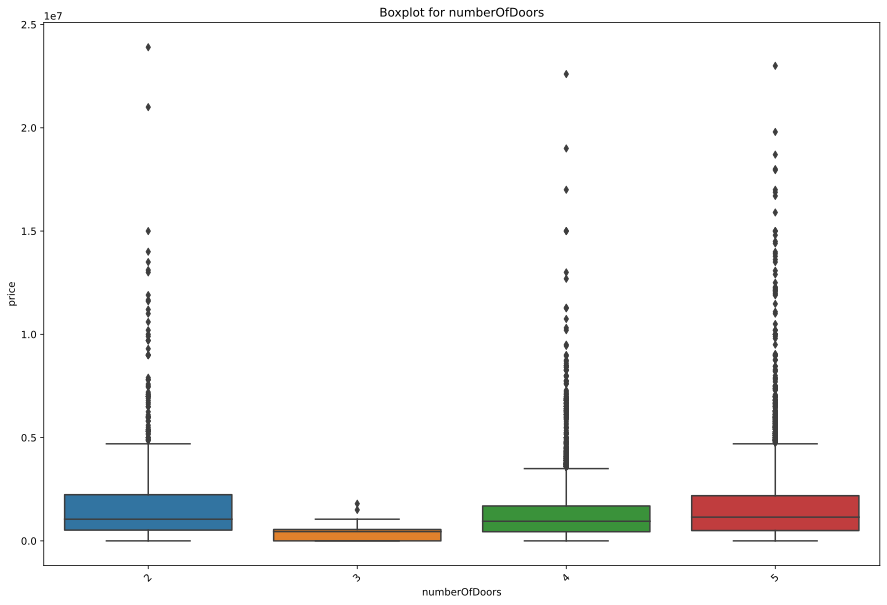

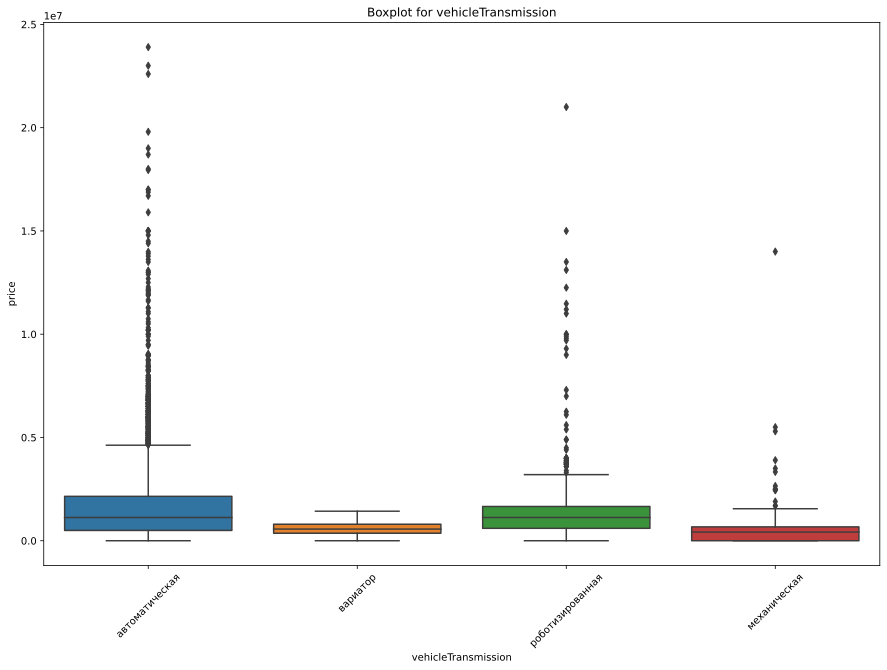

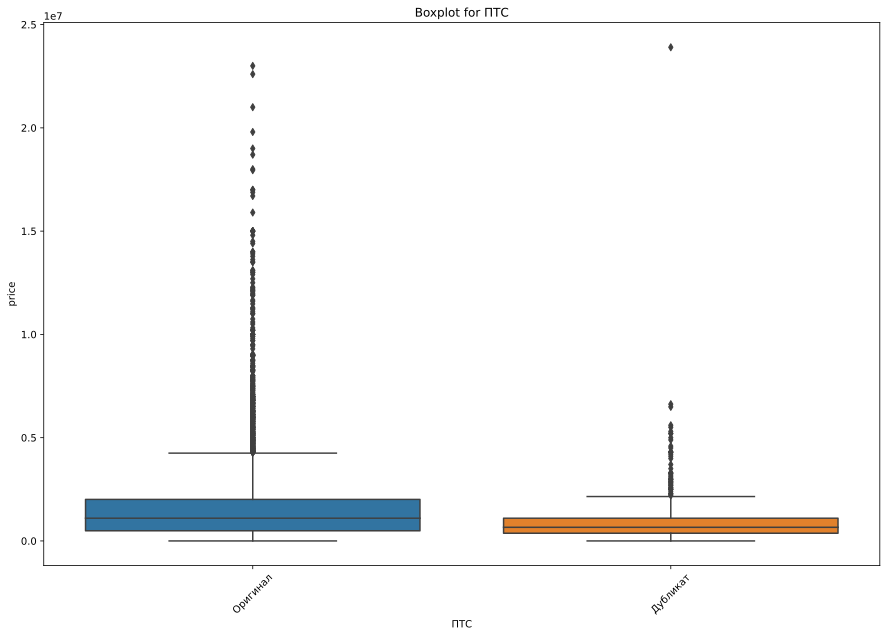

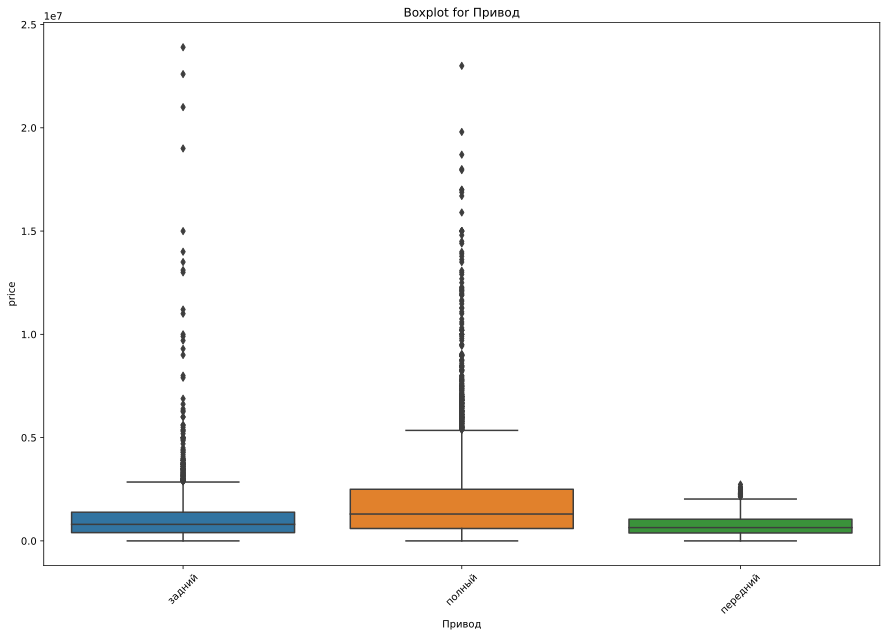

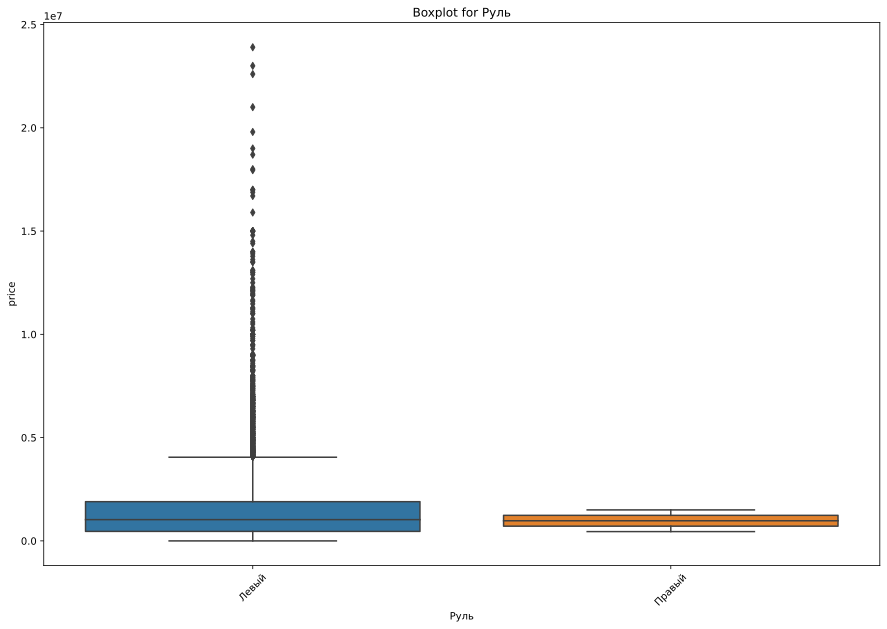

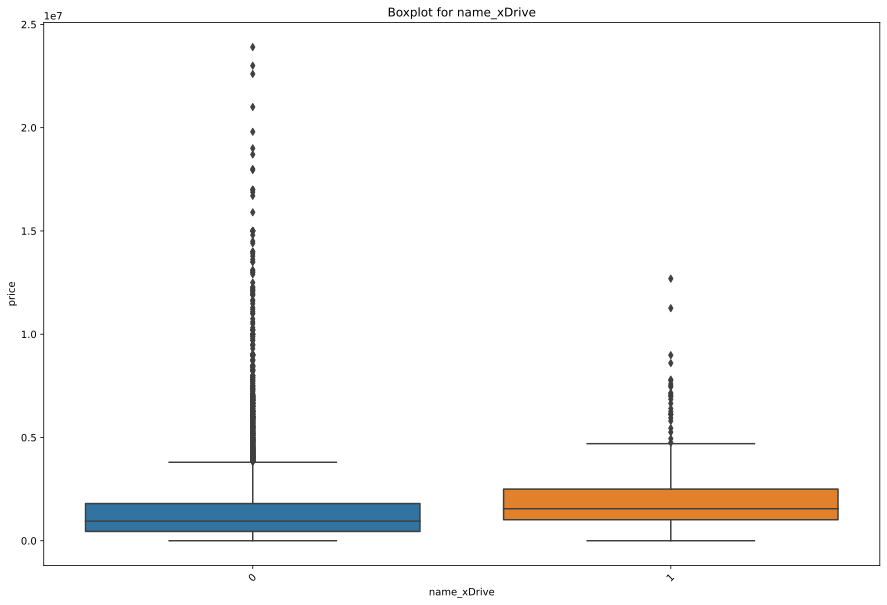

In [94]:
# график  плотность распределения переменных
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(x=column, y='price',
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# Посмотрим  на категориальные признаки:
for column in cat_cols:
    get_boxplot(column)

In [95]:
# Проведем тест Стьюдента для определения наиболее значимых для результата признаков 
# Как видим, все категориальные значения, кроме Руль, значимы. Удаляем Руль и name, поскольку дублируется name1 и name2
from itertools import combinations
from scipy.stats import ttest_ind

def get_student(column):
# тест Стьюдента

    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
#    display (combinations_all)
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'price'], 
                        data.loc[data.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
colns = cat_cols + num_cols + NL_col
for col in colns:
    get_student(col)

Найдены статистически значимые различия для колонки bodyType
Найдены статистически значимые различия для колонки brand
Найдены статистически значимые различия для колонки color
Найдены статистически значимые различия для колонки engineDisplacement
Найдены статистически значимые различия для колонки fuelType
Найдены статистически значимые различия для колонки model_info
Найдены статистически значимые различия для колонки numberOfDoors
Найдены статистически значимые различия для колонки vehicleTransmission
Найдены статистически значимые различия для колонки ПТС
Найдены статистически значимые различия для колонки Привод
Найдены статистически значимые различия для колонки name_xDrive
Найдены статистически значимые различия для колонки enginePower
Найдены статистически значимые различия для колонки productionAge
Найдены статистически значимые различия для колонки Владельцы
Найдены статистически значимые различия для колонки pow_eng
Найдены статистически значимые различия для колонки Владени

In [96]:
# Удалим явно незначимые столбцы и ненужные на этоп этапе обучения

#data_2 = data.copy()

#data = data.drop(['sell_id', 'Руль'], axis = 1)  # 'mileage', 'mil_year'

# PreProc Tabular Data

In [97]:
#список для Target encoding
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 
                        'engineDisplacement','vehicleTransmission', 'ПТС', 'Привод', 'model_info','name_xDrive']

#список для one-hot encoding 
categorical_oh = []

# текстовые, требущие обработки сетью
NL_col = ['description', 'name']

#используем все числовые признаки
numerical_features = ['enginePower','mileage', 'productionAge', 'Владельцы','Владение', 'pow_eng', 'mil_year']

#бинарные признаки
#binary_features=['Руль']
new_binary_features=['new', 'rare', 'LY_prod']

In [98]:
# # ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
# train['sample'] = 1 # помечаем где у нас трейн
# test['sample'] = 0 # помечаем где у нас тест
# test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

# data = test.append(train, sort=False).reset_index(drop=True) # объединяем
# print(train.shape, test.shape, data.shape)

In [99]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id','Руль','name','modelDate','modelAge'], axis = 1, inplace=True)
       
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
           
    # Нормализация данных
    #scaler = MinMaxScaler()
    #Лучший результат RobustScaler - 
    scaler = RobustScaler()
    for column in numerical_features:
        # Логарифмируем числовые переменные
        df_output[column] = df_output[column].apply(lambda x: np.log(float(x)+1))
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
     # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_oh:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_oh, dummy_na=False)

    # тут ваш код не Encoding фитчей
    
    #В итоге в общем случае лучший итог для всех категориальных переменных - OneHot 
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False) 

    #targ_enc = TargetEncoder(smoothing=8, min_samples_leaf=5)
    #targ_enc.fit(df_output[df_output['is_train']==1][categorical_features], df_output[df_output['is_train']==1]['price'])
    #df_output[categorical_features] = targ_enc.transform(df_output[categorical_features])
    
    return df_output

In [100]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,enginePower,mileage,productionDate,Владельцы,Владение,is_train,price,price_log,productionAge,rare,...,model_info_X6_M,model_info_X7,model_info_X_KLASSE,model_info_Z1,model_info_Z3,model_info_Z3M,model_info_Z4,model_info_Z8,name_xDrive_0,name_xDrive_1
6733,1.732745,-0.003361,2014,0.415037,-0.552605,1,1998000.0,7.600402,-0.152003,0,...,0,0,0,0,0,0,0,0,1,0
3929,-0.602327,0.014018,2011,0.000000,0.468829,1,950000.0,6.857514,0.263034,0,...,0,0,0,0,0,0,0,0,1,0
4476,0.578599,0.201283,2012,0.000000,0.325798,1,1197000.0,7.088409,0.137504,0,...,0,0,0,0,0,0,0,0,1,0
5577,0.553040,0.394924,2011,0.415037,-0.122010,1,1370000.0,7.223296,0.263034,0,...,0,0,0,0,0,0,0,0,1,0
7754,0.147532,0.394338,2013,0.415037,-0.398744,1,1575000.0,7.362645,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
5859,0.115686,0.242923,2014,0.000000,0.514964,1,1555555.0,7.350230,-0.152003,0,...,0,0,0,0,0,0,0,0,1,0
1992,-0.721301,0.487580,2007,0.415037,0.325798,1,350000.0,5.860786,0.678072,0,...,0,0,0,0,0,0,0,0,1,0
5440,-0.446960,0.523786,2013,0.000000,0.170314,1,1100000.0,7.003974,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
1701,0.147532,-0.310512,2017,-0.584963,0.325798,1,2349000.0,7.762171,-0.736966,0,...,0,0,0,0,0,0,0,0,0,1
474,0.115686,0.127621,2013,0.000000,0.170314,0,0.0,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,0,1


In [101]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 235 entries, enginePower to name_xDrive_1
dtypes: float64(9), int64(5), uint8(221)
memory usage: 2.7 MB


In [102]:
#data.drop(columns=['modelDate','modelAge','productionDate','Руль'], inplace=True)


## Split data

In [103]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('is_train == 1').drop(['is_train'], axis=1)
test_data = df_preproc.query('is_train == 0').drop(['is_train'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [104]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 234 entries, enginePower to name_xDrive_1
dtypes: float64(9), int64(4), uint8(221)
memory usage: 543.4 KB


# Model 2: CatBoostRegressor

In [105]:
#Разделение выборок
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=43)

In [106]:
model_catboos = CatBoostRegressor(iterations = 8000,        #Максимальное число итераций
                          #learning_rate = 0.03,     #Темп обучения
                          #l2_leaf_reg = 6,          #К-т при регуляризации
                          #depth = 7,                #Максимальная глубина деревьев
                          #min_data_in_leaf = 1,     #Минимальное число прецендентов в лепестке
                          #random_strength = 0.7,    #Процент от выборки для валидации
                          random_seed = 43,         #Воспроизведение результатов
                          eval_metric = 'MAPE',     #Метрика
                          od_wait = 500,            #Количество итераций после достижения оптимума
                          #task_type='GPU',
                          custom_metric=['RMSE', 'MAE']
)

#Обучение
model_catboos.fit(X, y,eval_set=(X_val, (y_val)),verbose_eval=100, use_best_model=True)#plot=True)

Learning rate set to 0.019298
0:	learn: 0.9863254	test: 0.9720759	best: 0.9720759 (0)	total: 57.4ms	remaining: 7m 38s
100:	learn: 0.1909201	test: 0.1875567	best: 0.1875567 (100)	total: 434ms	remaining: 33.9s
200:	learn: 0.0578203	test: 0.0571138	best: 0.0571138 (200)	total: 780ms	remaining: 30.2s
300:	learn: 0.0446846	test: 0.0443790	best: 0.0443790 (300)	total: 1.09s	remaining: 28s
400:	learn: 0.0357747	test: 0.0357220	best: 0.0357217 (399)	total: 1.43s	remaining: 27.2s
500:	learn: 0.0293508	test: 0.0292342	best: 0.0292342 (500)	total: 1.84s	remaining: 27.6s
600:	learn: 0.0254902	test: 0.0252287	best: 0.0252276 (598)	total: 2.44s	remaining: 30s
700:	learn: 0.0228216	test: 0.0224213	best: 0.0224213 (700)	total: 2.98s	remaining: 31.1s
800:	learn: 0.0207428	test: 0.0202146	best: 0.0202146 (800)	total: 3.31s	remaining: 29.8s
900:	learn: 0.0189648	test: 0.0184186	best: 0.0184186 (900)	total: 3.65s	remaining: 28.8s
1000:	learn: 0.0179307	test: 0.0173277	best: 0.0173273 (999)	total: 3.98s	re

In [107]:
test_predict_catboost = (model_catboos.predict(X_val))
print(f"TEST mape: {(mape(y_val, test_predict_catboost))*100:0.2f}%")

TEST mape: 0.40%


In [108]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [109]:
# model = CatBoostRegressor(iterations = 5000,
#                           #depth=10,
#                           #learning_rate = 0.5,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['RMSE', 'MAE'],
#                           od_wait=500,
#                           #task_type='GPU',
#                          )
# model.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=100,
#          use_best_model=True,
#          #plot=True
#          )

In [110]:
# test_predict_catboost = np.exp(model.predict(X_test))
# print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

### Submission

In [111]:
sub_predict_catboost = np.exp(model_catboos.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


# Model _. GradientBoostingRegressor

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [113]:
GBR1 = GradientBoostingRegressor(random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=250, max_depth=5)
GBR1.fit(X_train, np.log(y_train))

predict_GBR_test = np.exp(GBR1.predict(X_test))
predict_GBR_submission = np.exp(GBR1.predict(X_sub))

print(f"TEST mape: {(mape(y_test, predict_GBR_test))*100:0.2f}%")

TEST mape: 0.07%


In [114]:
sample_submission['price'] = predict_GBR_submission
sample_submission.to_csv('GBR1_submission.csv', index=False)

In [115]:
#Пробуем градиентный бустинг с подобранными гиперпараметрами
GBR2 = GradientBoostingRegressor(random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=1000, max_depth=10)
GBR2.fit(X_train, np.log(y_train))

predict_GBR2_test = np.exp(GBR2.predict(X_test))
predict_GBR2_submission = np.exp(GBR2.predict(X_sub))

print(f"TEST mape: {(mape(y_test, predict_GBR2_test))*100:0.2f}%")

TEST mape: 0.06%


In [116]:
sample_submission['price'] = predict_GBR2_submission
sample_submission.to_csv('GBR2_submission.csv', index=False)

In [117]:
#Пробуем градиентный бустинг с подобранными гиперпараметрами
GBR3 = GradientBoostingRegressor(random_state=RANDOM_SEED, learning_rate=0.12, n_estimators=500, max_depth=5)
GBR3.fit(X_train, np.log(y_train))

predict_GBR3_test = np.exp(GBR3.predict(X_test))
predict_GBR3_submission = np.exp(GBR3.predict(X_sub))

print(f"TEST mape: {(mape(y_test, predict_GBR3_test))*100:0.2f}%")

TEST mape: 0.09%


In [118]:
sample_submission['price'] = predict_GBR3_submission
sample_submission.to_csv('GBR3_submission.csv', index=False)

# Model. ExtraTreesRegressor

In [119]:
ETR1 = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_SEED)
ETR1.fit(X_train, np.log(y_train))

predict_ETR1_test = np.exp(ETR1.predict(X_test))
predict_ETR1_submission = np.exp(ETR1.predict(X_sub))

print(f"TEST mape: {(mape(y_test, predict_ETR1_test))*100:0.2f}%")

TEST mape: 0.19%


In [120]:
sample_submission['price'] = predict_ETR1_submission
sample_submission.to_csv('ETR1_submission.csv', index=False)

In [121]:
#Пробуем модель с учетом уточненных гиперпараметров 
ETR2 = ExtraTreesRegressor(n_estimators=500, max_depth=20, n_jobs=-1, random_state=RANDOM_SEED)
ETR2.fit(X_train, np.log(y_train))

predict_ETR2_test = np.exp(ETR2.predict(X_test))
predict_ETR2_submission = np.exp(ETR2.predict(X_sub))

print(f"TEST mape: {(mape(y_test, predict_ETR2_test))*100:0.2f}%")

TEST mape: 0.12%


In [122]:
sample_submission['price'] = predict_ETR2_submission
sample_submission.to_csv('ETR2_submission.csv', index=False)

# Models Stacking

Попробуем стекинг моделей. В качестве базовых моделей выберем две с лучшими результатами - GradientBoostingRegressor & ExtraTreesRegressor

In [123]:
estimators = [('GBR3', GBR3),
              ('ETR2', ETR2)]

In [124]:
#Попробуем в качестве мета-алгоритма LinearRegression
reg2 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

reg2.fit(X_train, np.log(y_train))
predict_reg2_test = np.exp(reg2.predict(X_test))
predict_reg2_submission = np.exp(reg2.predict(X_sub))

print(f"TEST mape: {(mape(y_test, predict_reg2_test))*100:0.2f}%")

TEST mape: 0.10%


In [125]:
sample_submission['price'] = predict_reg2_submission
sample_submission.to_csv('stack__submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [126]:
X_train.head(5)

,enginePower,mileage,productionDate,Владельцы,Владение,price_log,productionAge,rare,LY_prod,pow_eng,...,model_info_X6_M,model_info_X7,model_info_X_KLASSE,model_info_Z1,model_info_Z3,model_info_Z3M,model_info_Z4,model_info_Z8,name_xDrive_0,name_xDrive_1
1722,1.020435,0.355687,2008,0.000000,0.839868,7.055313,0.584963,0,0,-1.075053,...,0,0,0,0,0,0,0,0,1,0
4987,-0.684850,0.724692,2011,-0.584963,1.268735,7.273093,0.263034,0,0,-0.668133,...,0,0,0,0,0,0,0,0,1,0
7458,0.553040,-0.439304,2012,0.000000,0.059746,7.650169,0.137504,0,0,0.495332,...,0,0,0,0,0,0,0,0,1,0
5820,-0.177991,-0.661145,2014,-0.584963,1.050340,7.415175,-0.152003,0,0,0.662429,...,0,0,0,0,0,0,0,0,1,0
8256,0.115686,0.319126,2015,0.415037,-0.726330,7.408531,-0.321928,0,0,-0.451507,...,0,0,0,0,0,0,0,0,1,0


## Simple Dense NN

In [127]:
#del model

In [128]:
model = Sequential()
#Замена функцию активации на сигмоид ухудшает результат
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
#Добавление еще одного полносвязного слоя ухудшает показатели
#model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

2022-12-19 12:21:25.804143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 12:21:25.896873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 12:21:25.897656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 12:21:25.899789: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [129]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               119808    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 251,393
Trainable params: 251,393
Non-trainable params: 0
_________________________________________________________________


In [130]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [131]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [132]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

2022-12-19 12:21:30.250797: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


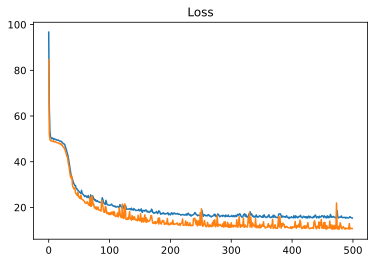

In [133]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [134]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [135]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.76%


In [136]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [137]:
# data.description

In [138]:
# Удалим из описания некоторые части речи - пытаемся избавиться от слов без смысловой нагрузки
import pymorphy2  # $ pip install pymorphy2

def pos(word, morth=pymorphy2.MorphAnalyzer()):
    "Return a likely part of speech for the *word*."""
    return morth.parse(word)[0].tag.POS
functors_main = {'INTJ', 'CONJ', 'PREP'}

In [139]:
# #
## morph = pymorphy2.MorphAnalyzer()
## data_NLP = data.copy()
## data.description = data.description.apply(lambda x: " ".join([word for word in x.split() if pos(word) not in functors_main]))
## #создадим функцию. в которой будет и лемматизация и очистка текста
## patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
## def lemmatize(doc):
##     doc = re.sub(patterns, ' ', doc)
##     tokens = []
##     for token in doc.split():
##         token = token.strip()
# #        token = morph.normal_forms(token)[0]
##         tokens.append(token)
# #    return ' '.join(tokens)

## import nltk
## nltk.download("stopwords")
## data_NLP['description'] = data_NLP.apply(
##     lambda data_NLP: lemmatize(data_NLP.description), axis=1)

In [140]:
data.description = data.description.apply(lambda x: " ".join([word for word in x.split() if pos(word) not in functors_main]))

In [141]:
# Лемматизация
morph = pymorphy2.MorphAnalyzer()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+●•✅☑️☛"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [142]:
data_NLP = data.copy()
data['description'] = data_NLP.apply(lambda data_NLP: lemmatize(data_NLP.description), axis=1)

In [143]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [144]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [145]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n•–∙—″☑️✔➥●·✅☛———————————————————————————')
tokenize.fit_on_texts(data.description)

CPU times: user 1.11 s, sys: 9.02 ms, total: 1.12 s
Wall time: 1.12 s


In [146]:
tokenize.word_index

{'автомобиль': 1,
 'не': 2,
 'система': 3,
 'задний': 4,
 'всё': 5,
 'пробег': 6,
 'салон': 7,
 'сидение': 8,
 'передний': 9,
 'машина': 10,
 '2': 11,
 'комплект': 12,
 'год': 13,
 'официальный': 14,
 'ваш': 15,
 'кредит': 16,
 'вы': 17,
 'диск': 18,
 'новый': 19,
 'авто': 20,
 'состояние': 21,
 'пакет': 22,
 'фара': 23,
 'безопасность': 24,
 'руль': 25,
 'колесо': 26,
 'дилер': 27,
 'гарантия': 28,
 'состоянии': 29,
 'птс': 30,
 'обмен': 31,
 'контроль': 32,
 'комплектация': 33,
 'bmw': 34,
 'быть': 35,
 '000': 36,
 'два': 37,
 'более': 38,
 'полный': 39,
 'весь': 40,
 'покупка': 41,
 'зеркало': 42,
 'датчик': 43,
 '1': 44,
 'есть': 45,
 'только': 46,
 'мы': 47,
 'продажа': 48,
 'отличный': 49,
 'автомобиля': 50,
 'один': 51,
 'водитель': 52,
 'подушка': 53,
 'шина': 54,
 'пассажир': 55,
 '6': 56,
 'двигатель': 57,
 'хороший': 58,
 'подогрев': 59,
 'км': 60,
 'любой': 61,
 'обогрев': 62,
 '3': 63,
 'юридический': 64,
 'проверка': 65,
 'обслуживание': 66,
 'технический': 67,
 'оригинал

Благодаря получившемуся словарю мы сможем произвести дальнейшую векторизацию нашего текста.

In [147]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )


(5679, 256) (1003, 256) (1671, 256)
CPU times: user 995 ms, sys: 4.98 ms, total: 1 s
Wall time: 1e+03 ms


In [148]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

продажа автомобиль компания ао abtodom, официальный дилер (bmw, mini, bmw i, bmw motorrad) 01cc auto start/stop function 01cd brake energy regeneration 0205 автоматический коробка передача 0216 гидроусилит.руль - сервотроника 0240 рулевой колесо нпб, кожа 0258 шина допускать движ.ть аварийный режим 02k0 л/c диск bmw v-образн.спица 02pa фиксатор колёсный болт 03at полоз баг.ич кр., сатиниров.алюм. 0428 знак аварийный остановка аптечка 0494 система обогр.сиден.водителя/перед.пасс. 04cg декоративный планка "satin-silber" мат. 0502 система омыватель фара 0508 сигнализация авар.сближен.переть парк.(pdc) 0520 фара противотуманный 0522 ксеноновый фара 0563 пакет светотехник 0663 радиоприёмник bmw professional 06ud языковой версия русский 0701 код 5 dvd 0842 исполнение страна холодный климат 0845 акустич.предупрежд.неприст.ремень безоп. 0874 radio frequency 434 mhz 0891 бортовый документация, русский 08lr управление странам, россия 10323 08sc открыт.доп.телем.услуг,ть завис.от страна 08tn днев

### RNN NLP

Теперь строим сеть для обработки текста. Для простоты в примере используем LSTM:

In [149]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(64, activation="sigmoid")) #добавим полносвязный слой
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))


### MLP

Эта сеть построена «без головы». Добавим ещё одну сеть — созданную нами ранее для табличных данных:

In [150]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dense(256, activation="relu")) #добавим еще один полносвязный слой
model_mlp.add(L.Dropout(0.5))


### Multiple Inputs NN

Осталось объединить их в Multi-Input сеть, т.е. сеть, которая позволяет брать на вход несколько сетей и объединять их результаты. За объединение отвечает слой L.concatenate:

In [151]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [152]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     8083968     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
______________________________________________________________________________________________

### Fit

In [153]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [154]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'],save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]


In [155]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=350, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/350


2022-12-19 12:28:44.076769: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 6s 201ms/step - loss: 99.6958 - MAPE: 99.6958 - val_loss: 97.3059 - val_MAPE: 97.3059


TypeError: unhashable type: 'list'

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

In [ ]:
# Блендинг из решений от двух алгоритмов. Этот вариант показывает лучший результат
test_pred_blend2 = (test_predict_catboost + test_predict_nn2[:,0])/2
print(f"TEST mape: {(mape(y_test, test_pred_blend2))*100:0.2f}%")

In [ ]:
# Блендинг из решений от трех алгоритмов. Этот вариант показывает лучший результат
test_pred_blend3 = (test_predict_catboost + test_predict_nn2[:,0]+ test_predict_nn1[:,0])/3
print(f"TEST mape: {(mape(y_test, test_pred_blend3))*100:0.2f}%")

In [ ]:
sample_submission['price'] = (sub_predict_nn2[:,0] + sub_predict_catboost)/2
sample_submission.to_csv('nn2_cat_submission.csv', index=False)

In [ ]:
sample_submission['price'] = (sub_predict_nn2[:,0] + sub_predict_nn1[:,0] + sub_predict_catboost)/3
sample_submission.to_csv('nn2_nn1_cat_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, imname in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(imname) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

### albumentations

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images



## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [ ]:

# нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights='imagenet',
                                                                       include_top=False, input_shape=(size[1], size[0], 3))

In [ ]:
# Для начала, сеть, которую подгрузили,никак не обучаем. Будем обучать только верхние слои,которые мы рандомно инициализировали
efficientnet_model.trainable = True

In [ ]:
# Будем работать со слоями начиная с этого момента
fine_tune_at = len(efficientnet_model.layers)//2

# Keep all other layers frozen
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# проверим количество и статус слоев
print(len(efficientnet_model.layers))

# for layer in efficientnet_model.layers:
#     print(layer, layer.trainable)

In [ ]:
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'sigmoid'),  # изменим функцию активации
    L.LayerNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),#добавили еще один полносвязный слой 
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# NLP: немного изменим базовую архитектуру
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(), #добавили нормализацию
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(128, activation = 'sigmoid'), #добавили полносвязный слой с функцией активации sigmoid
    L.Dropout(0.5),
    L.LSTM(64),
    L.Dropout(0.25),
    L.Dense(64),
    L.Dropout(0.25)
    ])

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(35),
                    epochs=80,
                    validation_data = test_dataset.batch(35),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productionDate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")
